### Juan Manuel Ramirez, Natalia Laiton y Laura Ortiz

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
!unzip archive.zip

Archive:  archive.zip
  inflating: obj/0-with-mask.jpg     
  inflating: obj/0-with-mask.txt     
  inflating: obj/0.jpg               
  inflating: obj/0.txt               
  inflating: obj/1-with-mask.jpg     
  inflating: obj/1-with-mask.txt     
  inflating: obj/10-with-mask.jpg    
  inflating: obj/10-with-mask.txt    
  inflating: obj/100-with-mask.jpg   
  inflating: obj/100-with-mask.txt   
  inflating: obj/101-with-mask.jpg   
  inflating: obj/101-with-mask.txt   
  inflating: obj/103-with-mask.jpg   
  inflating: obj/103-with-mask.txt   
  inflating: obj/104-with-mask.jpg   
  inflating: obj/104-with-mask.txt   
  inflating: obj/105-with-mask.jpg   
  inflating: obj/105-with-mask.txt   
  inflating: obj/106-with-mask.jpg   
  inflating: obj/106-with-mask.txt   
  inflating: obj/107-with-mask.jpg   
  inflating: obj/107-with-mask.txt   
  inflating: obj/108-with-mask.jpg   
  inflating: obj/108-with-mask.txt   
  inflating: obj/109-with-mask.jpg   
  inflating: obj/109-with-ma

In [ ]:
# !pip install Pillow

In [ ]:
# pip install opencv-python

In [ ]:
from PIL import Image
import cv2

In [ ]:
txt_files = [file_path for file_path in os.listdir("obj/") if file_path.endswith(".txt")]

In [ ]:
random.shuffle(txt_files)

In [ ]:
test_files = txt_files[-100:]
val_files = txt_files[-200: -100]
train_files = txt_files[:-200]

In [ ]:
def yolobbox2bbox(x,y,w,h):

    x1, y1 = x-w/2, y-h/2
    x2, y2 = x+w/2, y+h/2

    return x1, y1, x2, y2

In [ ]:
def box_to_IoU(x,y,w,h):

    x1, y1, x2, y2 = yolobbox2bbox(x,y,w,h)

    return min(y1, y2), min(x1, x2), max(y1, y2), max(x1, x2)

In [ ]:
def split_gen(files):
    def example_generator():

        for annotation in files:

            with open(os.path.join("obj/", annotation), "r") as fp:
                lines = fp.readlines()
                if len(lines) > 1:
                    continue

            try:
                image_path = os.path.join("obj/", annotation.replace(".txt", ".jpg"))
                assert os.path.isfile(image_path)
            except AssertionError:
                continue
            else:
                image = Image.open(image_path)
                image_numpy = np.asanyarray(image)
                if image_numpy.shape[-1] != 3:
                    continue

                metadata = lines[0].strip().split(" ")

                classification_label = int(metadata[0])
                regression_values = [float(data) for data in metadata[1:]]
                regression_values = box_to_IoU(regression_values[0], regression_values[1], regression_values[2], regression_values[3])

            yield image_numpy, (classification_label, regression_values)

    return example_generator

In [ ]:
gen = split_gen(test_files)

In [ ]:
next(gen())

(array([[[185, 214, 244],
         [185, 214, 244],
         [185, 214, 244],
         ...,
         [210, 239, 255],
         [211, 238, 255],
         [208, 235, 254]],
 
        [[185, 214, 244],
         [185, 214, 244],
         [185, 214, 244],
         ...,
         [207, 236, 254],
         [208, 235, 254],
         [205, 232, 251]],
 
        [[185, 214, 244],
         [185, 214, 244],
         [185, 214, 244],
         ...,
         [206, 233, 252],
         [206, 233, 250],
         [204, 231, 248]],
 
        ...,
 
        [[  0, 115, 224],
         [  0, 114, 223],
         [  0, 114, 223],
         ...,
         [112, 159, 189],
         [112, 159, 189],
         [112, 159, 189]],
 
        [[  1, 113, 221],
         [  0, 112, 220],
         [  0, 112, 220],
         ...,
         [112, 159, 189],
         [112, 159, 189],
         [112, 159, 189]],
 
        [[  0, 112, 220],
         [  0, 112, 220],
         [  0, 111, 219],
         ...,
         [112, 159, 189],
  

In [ ]:
training_dataset = tf.data.Dataset.from_generator(
     split_gen(train_files),
     output_signature=(
         tf.TensorSpec(shape=(None, None ,3), dtype=tf.float32),
         (tf.TensorSpec(shape=(), dtype=tf.int32),
         tf.TensorSpec(shape=(4,), dtype=tf.float32))
     ),

)
validation_dataset = tf.data.Dataset.from_generator(
     split_gen(val_files),
     output_signature=(
         tf.TensorSpec(shape=(None, None ,3), dtype=tf.float32),
         (tf.TensorSpec(shape=(), dtype=tf.int32),
         tf.TensorSpec(shape=(4,), dtype=tf.float32))
     ),

)
test_dataset = tf.data.Dataset.from_generator(
     split_gen(test_files),
     output_signature=(
         tf.TensorSpec(shape=(None, None ,3), dtype=tf.float32),
         (tf.TensorSpec(shape=(), dtype=tf.int32),
         tf.TensorSpec(shape=(4,), dtype=tf.float32))
     ),

)

In [ ]:
for b in training_dataset.take(1):
    print(b)

(<tf.Tensor: shape=(428, 320, 3), dtype=float32, numpy=
array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 2

In [ ]:
training_dataset = (
    training_dataset
    .map(lambda image, labels: (tf.image.resize(image, (256, 256)), labels)))
validation_dataset = (
    validation_dataset
    .map(lambda image, labels: (tf.image.resize(image, (256, 256)), labels)))
test_dataset = (
    test_dataset
    .map(lambda image, labels: (tf.image.resize(image, (256, 256)), labels)))

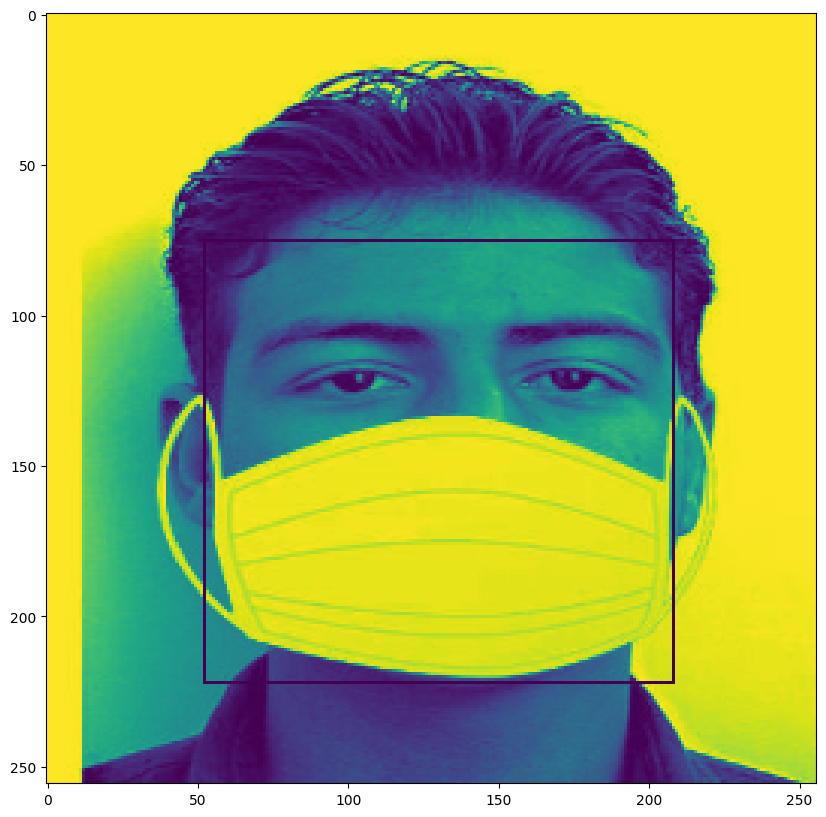

In [ ]:
plt.figure(figsize=(20, 10))
for image, (label_1, label_2) in training_dataset.skip(13).take(1):

    box = tf.cast(label_2 * 256, tf.int32).numpy()
    image_color = cv2.cvtColor(image.numpy(), cv2.COLOR_BGR2GRAY)
    cv2.rectangle(image_color, pt1=(int(box[1]), int(box[2])), pt2=(int(box[3]), int(box[0])), color=(0, 255, 0))
    plt.imshow(image_color)


In [ ]:
training_dataset = training_dataset.cache().shuffle(1_000).batch(32).prefetch(5)
validation_dataset = validation_dataset.cache().batch(32).prefetch(5)
test_dataset = test_dataset.cache().batch(32).prefetch(5)

# Modelo

## 1. Añadir data Augmentation

In [ ]:
## Clasificador
inputs = tf.keras.layers.Input((256, 256, 3), dtype=tf.float32, name="input_image")
rescaling = tf.keras.layers.Rescaling(1. / 255)(inputs)

# Augmentation ???
flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")(rescaling)
rot = tf.keras.layers.RandomRotation(0.2)(flip)
zoom = tf.keras.layers.RandomZoom((0.2,.5),(0.2,.5))(rot)

# Bloques convolucionales

conv_1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_1")(zoom)
max_pool_1 = tf.keras.layers.MaxPool2D(name="max_pool_1")(conv_1)

conv_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_2")(max_pool_1)
max_pool_2 = tf.keras.layers.MaxPool2D(name="max_pool_2")(conv_2)

conv_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_3")(max_pool_2)
max_pool_3 = tf.keras.layers.MaxPool2D(name="max_pool_3")(conv_3)

conv_4 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_4")(max_pool_3)
max_pool_4 = tf.keras.layers.MaxPool2D(name="max_pool_4")(conv_4)

conv_5 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_5")(max_pool_4)
max_pool_5 = tf.keras.layers.MaxPool2D(name="max_pool_5")(conv_5)

conv_6 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_6")(max_pool_5)
max_pool_6 = tf.keras.layers.MaxPool2D(name="max_pool_6")(conv_6)

x = tf.keras.layers.Flatten()(max_pool_6)
x = tf.keras.layers.Dropout(.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(.5)(x)

classification_head = tf.keras.layers.Dense(1, activation="sigmoid", name="classification_head")(x)
regression_head = tf.keras.layers.Dense(4, name="regression_head")(x)

model = tf.keras.Model(inputs=[inputs], outputs=[classification_head, regression_head])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_image[0][0]']         
                                                                                                  
 random_flip (RandomFlip)    (None, 256, 256, 3)          0         ['rescaling[0][0]']           
                                                                                                  
 random_rotation (RandomRot  (None, 256, 256, 3)          0         ['random_flip[0][0]']         
 ation)                                                                                       

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),
    loss = {
        'classification_head' : tf.keras.losses.BinaryCrossentropy(),
        'regression_head' : tf.keras.losses.MeanSquaredError()
    },
    metrics = {
        'classification_head' : 'accuracy',
        'regression_head' : ['mse', tfa.losses.GIoULoss(mode="iou")]
    })

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    training_dataset,
    epochs=50,
    callbacks=[early_stopping],
    validation_data=validation_dataset
)

Epoch 1/50
35/35 [==============================] - 40s 121ms/step - loss: 2.2545 - classification_head_loss: 0.6564 - regression_head_loss: 0.0952 - classification_head_accuracy: 0.6371 - regression_head_mse: 0.0952 - regression_head_giou_loss: 0.8160 - val_loss: 1.8987 - val_classification_head_loss: 0.6723 - val_regression_head_loss: 0.0193 - val_classification_head_accuracy: 0.5930 - val_regression_head_mse: 0.0193 - val_regression_head_giou_loss: 0.5136
Epoch 2/50
35/35 [==============================] - 2s 44ms/step - loss: 1.6864 - classification_head_loss: 0.6452 - regression_head_loss: 0.0485 - classification_head_accuracy: 0.6514 - regression_head_mse: 0.0485 - regression_head_giou_loss: 0.7199 - val_loss: 1.4838 - val_classification_head_loss: 0.6675 - val_regression_head_loss: 0.0193 - val_classification_head_accuracy: 0.5930 - val_regression_head_mse: 0.0193 - val_regression_head_giou_loss: 0.5465
Epoch 3/50
35/35 [==============================] - 1s 40ms/step - loss: 1.3

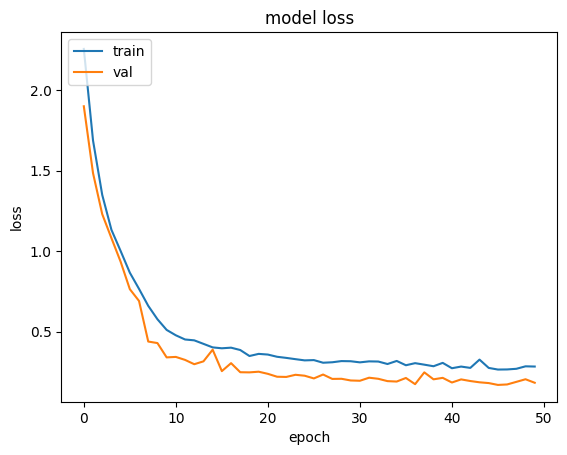

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
evaluation = model.evaluate(test_dataset)

3/3 [==============================] - 1s 637ms/step - loss: 0.2315 - classification_head_loss: 0.1420 - regression_head_loss: 0.0117 - classification_head_accuracy: 0.9545 - regression_head_mse: 0.0117 - regression_head_giou_loss: 0.4223


1/1 [==============================] - 1s 524ms/step


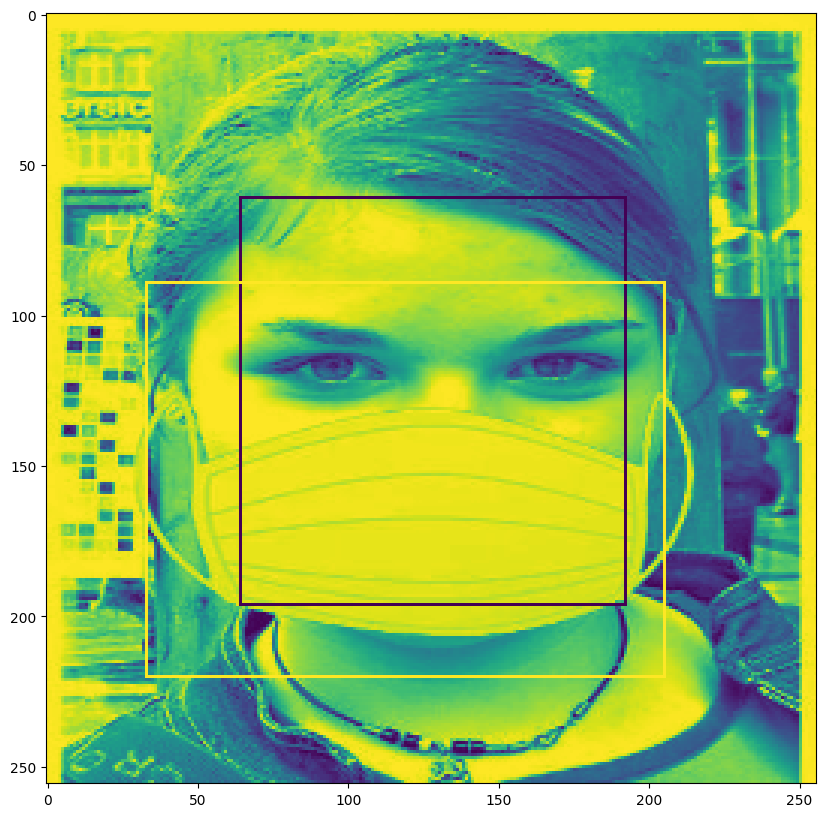

In [ ]:
plt.figure(figsize=(20, 10))
example = test_dataset.unbatch().batch(1).skip(10).take(1)
prediction = model.predict(example)
pred_box = prediction[1][0] * 256
true_box = example.get_single_element()[-1][-1].numpy()[0] * 256
image_color = cv2.cvtColor(example.get_single_element()[0].numpy()[0], cv2.COLOR_BGR2GRAY)
cv2.rectangle(image_color, pt1=(int(pred_box[1]), int(pred_box[2])), pt2=(int(pred_box[3]), int(pred_box[0])), color=(0, 255, 0))
cv2.rectangle(image_color, pt1=(int(true_box[1]), int(true_box[2])), pt2=(int(true_box[3]), int(true_box[0])), color=(255, 255, 255))
plt.imshow(image_color)

## 2. Encoder - Decoder

In [ ]:
## Clasificador
inputs = tf.keras.layers.Input((256, 256, 3), dtype=tf.float32, name="input_image")
rescaling = tf.keras.layers.Rescaling(1. / 255)(inputs)

# Augmentation ???
flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")(rescaling)
rot = tf.keras.layers.RandomRotation(0.2)(flip)
zoom = tf.keras.layers.RandomZoom((0.2,.5),(0.2,.5))(rot)

# Bloques convolucionales

conv_1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_1")(zoom)
max_pool_1 = tf.keras.layers.MaxPool2D(name="max_pool_1")(conv_1)

conv_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_2")(max_pool_1)
max_pool_2 = tf.keras.layers.MaxPool2D(name="max_pool_2")(conv_2)

conv_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_3")(max_pool_2)
max_pool_3 = tf.keras.layers.MaxPool2D(name="max_pool_3")(conv_3)

conv_4 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_4")(max_pool_3)
max_pool_4 = tf.keras.layers.MaxPool2D(name="max_pool_4")(conv_4)

conv_5 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_5")(max_pool_4)
max_pool_5 = tf.keras.layers.MaxPool2D(name="max_pool_5")(conv_5)

conv_6 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_6")(max_pool_5)
max_pool_6 = tf.keras.layers.MaxPool2D(name="max_pool_6")(conv_6)


# # Decoder
upsampling_4 = tf.keras.layers.UpSampling2D()(max_pool_6)
conv_7 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_7")(upsampling_4)

upsampling_8 = tf.keras.layers.UpSampling2D()(conv_7)
conv_8 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_8")(upsampling_8)

upsampling_16 = tf.keras.layers.UpSampling2D()(conv_8)
conv_9 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_9")(upsampling_16)

upsampling_32 = tf.keras.layers.UpSampling2D()(conv_9)
conv_10 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_10")(upsampling_32)

x = tf.keras.layers.Flatten()(conv_10)
x = tf.keras.layers.Dropout(.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(.5)(x)

classification_head = tf.keras.layers.Dense(1, activation="sigmoid", name="classification_head")(x)
regression_head = tf.keras.layers.Dense(4, name="regression_head")(x)

model2 = tf.keras.Model(inputs=[inputs], outputs=[classification_head, regression_head])

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['input_image[0][0]']         
                                                                                                  
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)          0         ['rescaling_1[0][0]']         
                                                                                                  
 random_rotation_1 (RandomR  (None, 256, 256, 3)          0         ['random_flip_1[0][0]']       
 otation)                                                                                   

In [ ]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),
    loss = {
        'classification_head' : tf.keras.losses.BinaryCrossentropy(),
        'regression_head' : tf.keras.losses.MeanSquaredError()
    },
    metrics = {
        'classification_head' : 'accuracy',
        'regression_head' : ['mse', tfa.losses.GIoULoss(mode="iou")]
    })

In [ ]:
history2 = model2.fit(
    training_dataset,
    epochs=50,
    callbacks=[early_stopping],
    validation_data=validation_dataset
)

Epoch 1/50
35/35 [==============================] - 10s 87ms/step - loss: 3.6292 - classification_head_loss: 0.6462 - regression_head_loss: 0.0669 - classification_head_accuracy: 0.6505 - regression_head_mse: 0.0669 - regression_head_giou_loss: 0.7586 - val_loss: 2.9556 - val_classification_head_loss: 0.6662 - val_regression_head_loss: 0.0189 - val_classification_head_accuracy: 0.5930 - val_regression_head_mse: 0.0189 - val_regression_head_giou_loss: 0.5516
Epoch 2/50
35/35 [==============================] - 2s 49ms/step - loss: 2.5170 - classification_head_loss: 0.6416 - regression_head_loss: 0.0383 - classification_head_accuracy: 0.6514 - regression_head_mse: 0.0383 - regression_head_giou_loss: 0.6724 - val_loss: 2.1206 - val_classification_head_loss: 0.6438 - val_regression_head_loss: 0.0206 - val_classification_head_accuracy: 0.5930 - val_regression_head_mse: 0.0206 - val_regression_head_giou_loss: 0.4975
Epoch 3/50
35/35 [==============================] - 2s 51ms/step - loss: 1.86

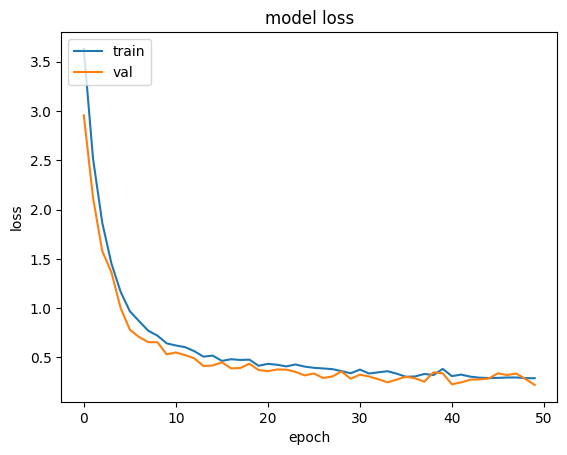

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
evaluation = model2.evaluate(test_dataset)

3/3 [==============================] - 0s 122ms/step - loss: 0.3343 - classification_head_loss: 0.2022 - regression_head_loss: 0.0142 - classification_head_accuracy: 0.9432 - regression_head_mse: 0.0142 - regression_head_giou_loss: 0.4731


1/1 [==============================] - 1s 612ms/step


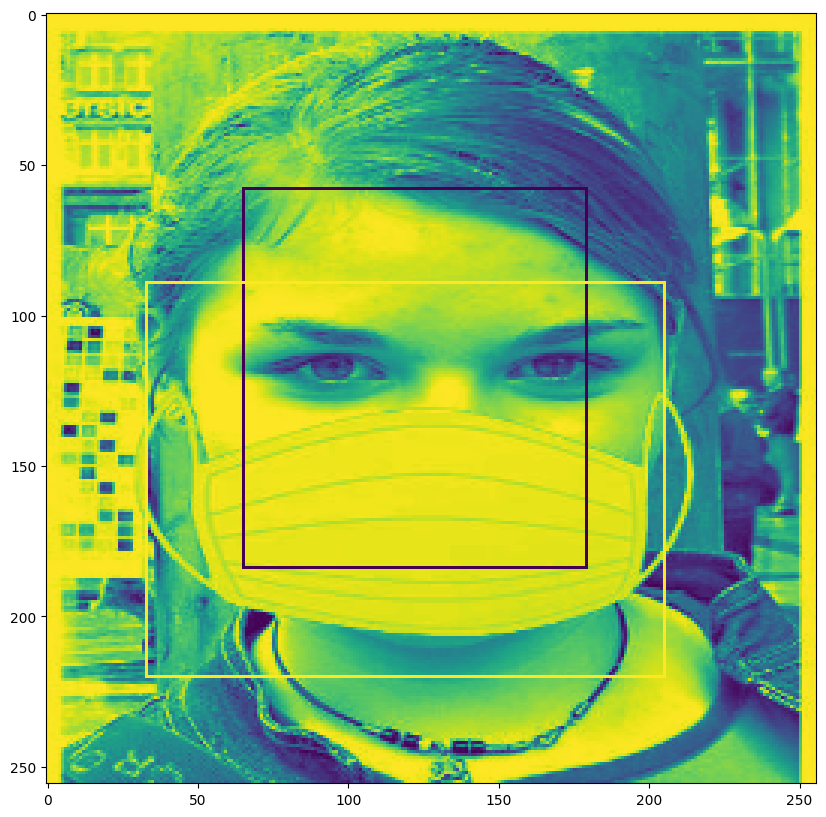

In [ ]:
plt.figure(figsize=(20, 10))
example = test_dataset.unbatch().batch(1).skip(10).take(1)
prediction = model2.predict(example)
pred_box = prediction[1][0] * 256
true_box = example.get_single_element()[-1][-1].numpy()[0] * 256
image_color = cv2.cvtColor(example.get_single_element()[0].numpy()[0], cv2.COLOR_BGR2GRAY)
cv2.rectangle(image_color, pt1=(int(pred_box[1]), int(pred_box[2])), pt2=(int(pred_box[3]), int(pred_box[0])), color=(0, 255, 0))
cv2.rectangle(image_color, pt1=(int(true_box[1]), int(true_box[2])), pt2=(int(true_box[3]), int(true_box[0])), color=(255, 255, 255))
plt.imshow(image_color)

## 3. Prueba del modelo

Exception ignored in: <function _xla_gc_callback at 0x7d7f83333d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


1/1 [==============================] - 0s 158ms/step


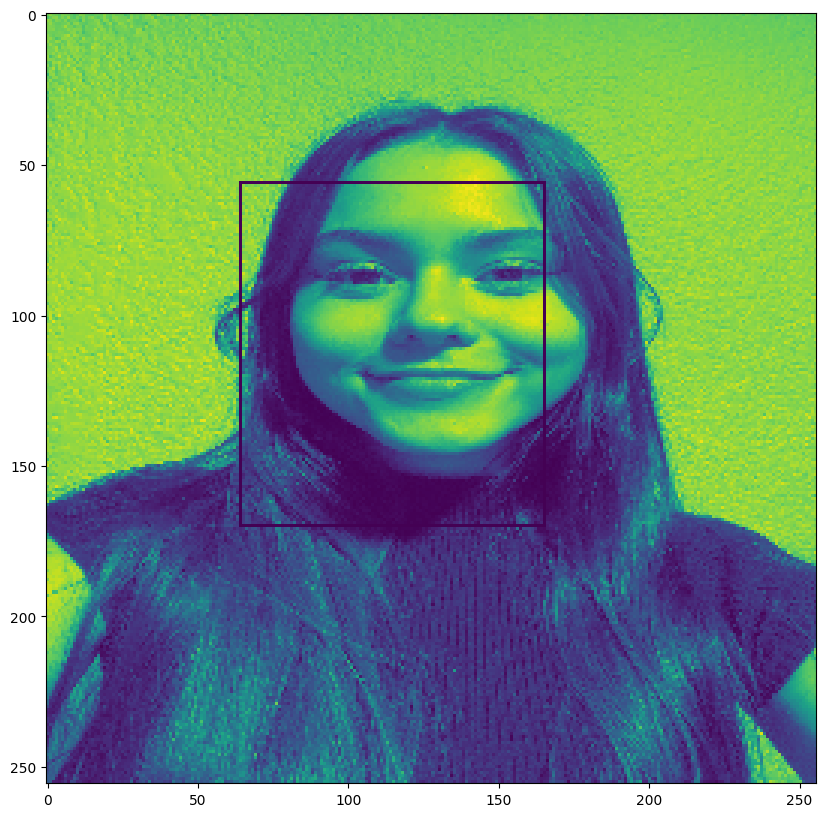

In [ ]:
plt.figure(figsize=(20, 10))
#base = tf.keras.preprocessing.image.img_to_array(cv2.imread('base.jpeg'))
base = cv2.resize(cv2.imread('base.jpeg'),(256, 256))
base = np.expand_dims(base, axis=0)


prediction = model2.predict(base)
pred_box = prediction[1][0] * 256

image_color = cv2.cvtColor(cv2.resize(cv2.imread('base.jpeg'),(256, 256)), cv2.COLOR_BGR2GRAY)
cv2.rectangle(image_color, pt1=(int(pred_box[1]), int(pred_box[2])), pt2=(int(pred_box[3]), int(pred_box[0])), color=(0, 255, 0))
plt.imshow(image_color)

1/1 [==============================] - 0s 20ms/step


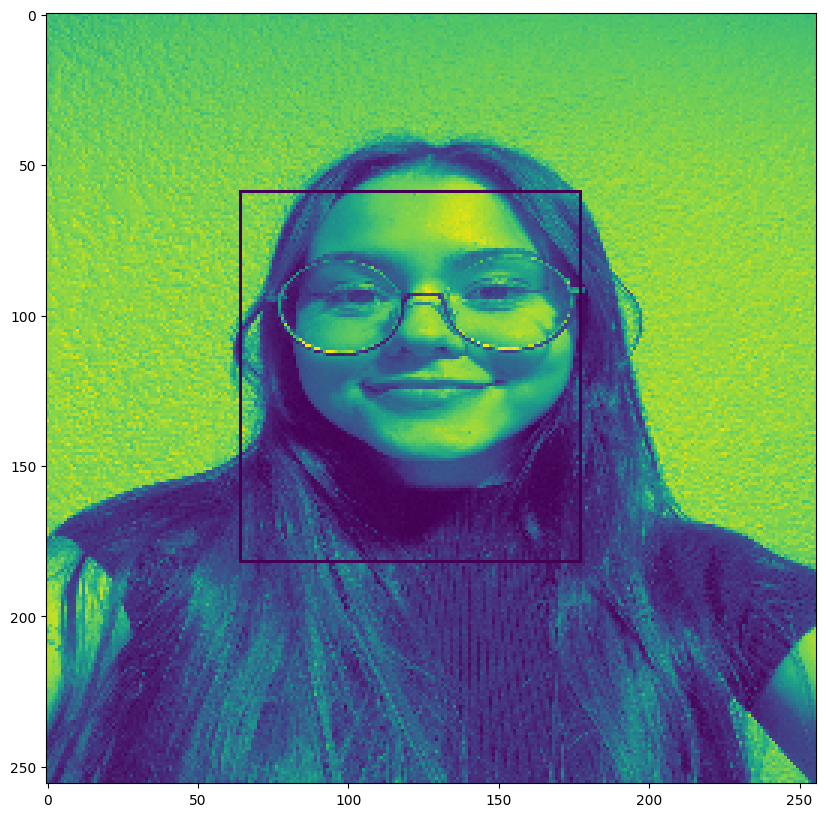

In [ ]:
plt.figure(figsize=(20, 10))
gafas = cv2.resize(cv2.imread('gafas.jpeg'),(256, 256))
gafas = np.expand_dims(gafas, axis=0)


prediction = model2.predict(gafas)
pred_box = prediction[1][0] * 256

image_color = cv2.cvtColor(cv2.resize(cv2.imread('gafas.jpeg'),(256, 256)), cv2.COLOR_BGR2GRAY)
cv2.rectangle(image_color, pt1=(int(pred_box[1]), int(pred_box[2])), pt2=(int(pred_box[3]), int(pred_box[0])), color=(0, 255, 0))
plt.imshow(image_color)

1/1 [==============================] - 0s 19ms/step


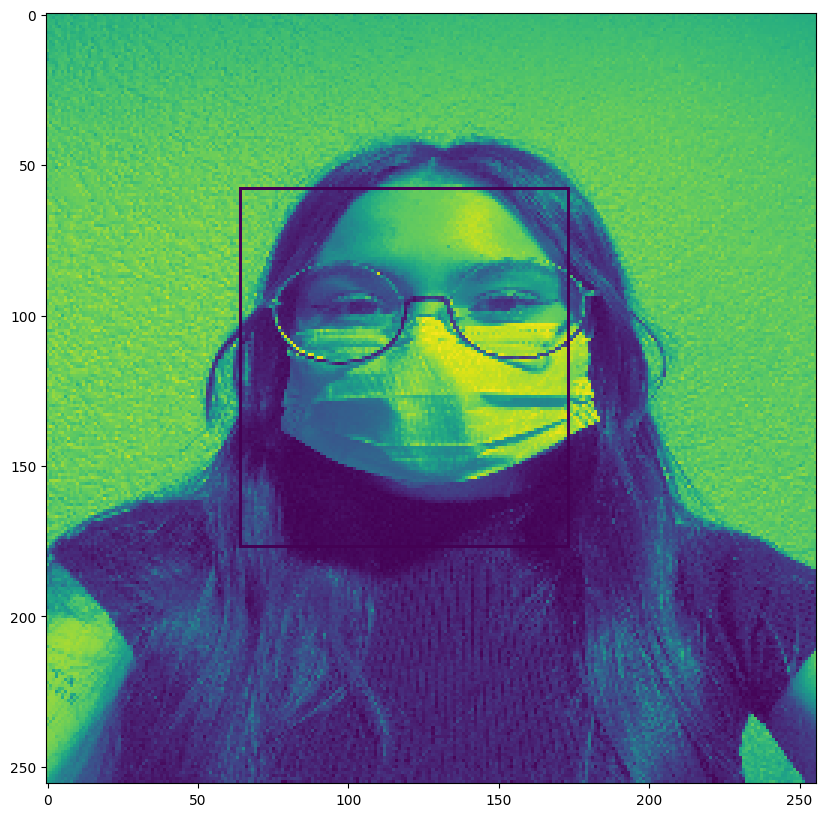

In [ ]:
plt.figure(figsize=(20, 10))
gafas_tapabocas = cv2.resize(cv2.imread('gafas_tapabocas.jpeg'),(256, 256))
gafas_tapabocas = np.expand_dims(gafas_tapabocas, axis=0)


prediction = model2.predict(gafas_tapabocas)
pred_box = prediction[1][0] * 256

image_color = cv2.cvtColor(cv2.resize(cv2.imread('gafas_tapabocas.jpeg'),(256, 256)), cv2.COLOR_BGR2GRAY)
cv2.rectangle(image_color, pt1=(int(pred_box[1]), int(pred_box[2])), pt2=(int(pred_box[3]), int(pred_box[0])), color=(0, 255, 0))
plt.imshow(image_color)

1/1 [==============================] - 0s 29ms/step


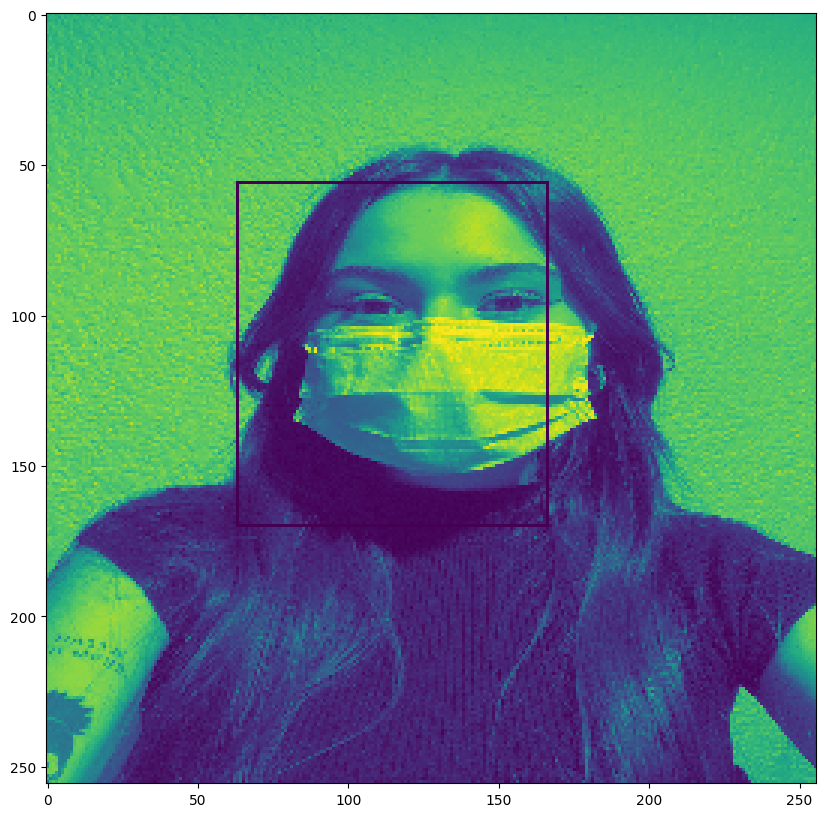

In [ ]:
plt.figure(figsize=(20, 10))
tapabocas = cv2.resize(cv2.imread('tapabocas.jpeg'),(256, 256))
tapabocas = np.expand_dims(tapabocas, axis=0)


prediction = model2.predict(tapabocas)
pred_box = prediction[1][0] * 256

image_color = cv2.cvtColor(cv2.resize(cv2.imread('tapabocas.jpeg'),(256, 256)), cv2.COLOR_BGR2GRAY)
cv2.rectangle(image_color, pt1=(int(pred_box[1]), int(pred_box[2])), pt2=(int(pred_box[3]), int(pred_box[0])), color=(0, 255, 0))
plt.imshow(image_color)